In [11]:
import xarray as xr
import s3fs
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
from netCDF4 import Dataset
from IPython import display
import matplotlib.pyplot as plt
import netCDF4
import pandas as pd
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')


In [52]:
### import from pangeo ###
def read_pangeo(start_year, end_year, experimentid):
    cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    col = intake.open_esm_datastore(cat_url)
    cat = col.search(source_id=['NorESM2-LM'], experiment_id=[experimentid], 
                     table_id=['day'], variable_id=['pr','clt','hus','va','tas'], member_id=['r1i1p1f1'])
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
    dataset_list = list(dset_dict.keys())
    start_year_ = start_year
    end_year_ = end_year
    df = dset_dict[dataset_list[0]]
    df_sliced = df.sel(time = slice(str(start_year)+"-01-01", str(end_year)+"-12-31"))
    return df_sliced

def read_to_detect(start_year, end_year, experimentid):
    cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    col = intake.open_esm_datastore(cat_url)
    cat = col.search(source_id=['NorESM2-LM'], experiment_id=[experimentid], 
                     table_id=['day'], variable_id=['hus','va'], member_id=['r1i1p1f1'])
    dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
    dataset_list = list(dset_dict.keys())
    start_year_ = start_year
    end_year_ = end_year
    df = dset_dict[dataset_list[0]]
    df = df.chunk(20)
    df_sliced = df.sel(time = slice(str(start_year)+"-01-01", str(end_year)+"-12-31"))
    return df_sliced

### AOD bias correction function ###


### import from "the bucket" ###
    
def read_aod(start_year, end_year, experimentid):
    s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                           secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                           client_kwargs=dict(endpoint_url="https://rgw.met.no"))

    if experimentid == 'historical': 
        s3path = list([
        'escience2022/Ada/monthly/od550aer_AERday_NorESM2-LM_historical_r1i1p1f1_gn_2000101-20141231.nc'
        ])
        sopenlist=[s3.open(ss) for ss in s3path]
        aod = (xr.open_dataset(sopenlist[0])).sel(time = slice(str(start_year)+"-01-01", str(end_year)+"-12-31"))

    elif experimentid == 'ssp245':
        s3path = list([
            'escience2022/Ada/monthly/od550aer_AERday_NorESM2-LM_ssp245_r1i1p1f1_gn_20150101-21001231.nc'
        ])
        sopenlist=[s3.open(ss) for ss in s3path]
        aod = (xr.open_dataset(sopenlist[0])).sel(time = slice(str(start_year)+"-01-01", str(end_year)+"-12-31"))
    
    elif experimentid == 'ssp370':
        s3path = list([
            'escience2022/Ada/monthly/od550aer_AERday_NorESM2-LM_ssp370_r1i1p1f1_gn_20150101-21001231.nc'
        ])
        sopenlist=[s3.open(ss) for ss in s3path]
        aod = (xr.open_dataset(sopenlist[0])).sel(time = slice(str(start_year)+"-01-01", str(end_year)+"-12-31"))
            
    elif experimentid == 'ssp585':
        s3path = list([
             'escience2022/Ada/monthly/od550aer_AERday_NorESM2-LM_ssp585_r1i1p1f1_gn_20150101-21001231.nc'
        ])

        sopenlist=[s3.open(ss) for ss in s3path]
        aod = (xr.open_dataset(sopenlist[0])).sel(time = slice(str(start_year)+"-01-01", str(end_year)+"-12-31"))
        
    else:
        print('something went wrong')

    return aod
    
    
def read_370(start_year, end_year):
    s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                           secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                           client_kwargs=dict(endpoint_url="https://rgw.met.no"))
    s3path = list([
        'escience2022/Remy/va_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20810101-20901231.nc',
        'escience2022/Remy/va_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20910101-21001231.nc',
        'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20810101-20901231.nc',
        'escience2022/Remy/hus_day_NorESM2-LM_ssp370_r1i1p1f1_gn_20910101-21001231.nc',
    ])

    sopenlist=[s3.open(ss) for ss in s3path]
    bucket370 = xr.open_mfdataset(sopenlist).drop(('lat_bnds', 'time_bnds', 'lon_bnds')).sel(time = 
                                                                                             slice(str(start_year)+"-01-01",
                                                                                                   str(end_year)+"-12-31"))
    
    return bucket370
                                                    

In [ ]:
'''Data treatment'''

In [ ]:
arh = xr.open_dataset('combined_hist_q94.nc')
ar245 = xr.open_dataset('ssp245_combined_q94.nc')
ar370 = xr.open_dataset('ssp370_combined_q94.nc')
ar585 = xr.open_dataset('ssp585_combined_q94.nc')

In [53]:
aodh = read_aod(2000, 2014, 'historical')
aod245 = read_aod(2085, 2099, 'ssp245')
aod370 = read_aod(2085, 2099, 'ssp370')
aod585 = read_aod(2085, 2099, 'ssp585')


In [ ]:
'''aodh['time']=arh.time
aod245['time']=ar245.time
aod370['time']=ar370.time
aod585['time']=ar585.time'''

In [77]:
### merge data sets with aod data Set###
dh = read_pangeo(2000, 2014, 'historical')
#dh = cmh.merge(aodh.drop('time_bnds'))

d245 = read_pangeo(2085, 2099, 'ssp245')
#d245= cm245.merge(aod245.drop('time_bnds'))

d585 = read_pangeo(2085, 2099, 'ssp585')
#d585 = cm585.merge(aod585.drop('time_bnds'))


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [ ]:
cm370 = read_pangeo(2085, 2099, 'ssp370')
cm370b  = read_370(2085,2099)
d370 = cm370.merge(cm370b)

In [ ]:
dh['clt'].values.max()

In [16]:
# slice to poles and slice only until pressure levels where AR can be detected
n245 = d245.sel(lat = slice(60,90),plev=slice(100000, 25000))
s245 =d245.sel(lat = slice(-90,-60),plev=slice(100000, 25000))

n370 = d370.sel(lat = slice(60,90),plev=slice(100000, 25000))
s370 =d370.sel(lat = slice(-90,-60),plev=slice(100000, 25000))

n585 = d585.sel(lat = slice(60,90),plev=slice(100000, 25000))
s585 =d585.sel(lat = slice(-90,-60),plev=slice(100000, 25000))

nh = dh.sel(lat = slice(60,90), plev=slice(100000, 25000))
sh =dh.sel(lat = slice(-90,-60), plev=slice(100000, 25000))


## mask data for being inside or outside of a atmospheric river
masked_n245 = n245.where(ar245['ivt']==True)
masked_n370 = n370.where(ar370['ivt']==True)
masked_n585 = n585.where(ar585['ivt']==True)
masked_nh = nh.where(arh['ivt']==True)
neg_n245 = n245.where(ar245['ivt']==False).where(n245['va'] > 0 )
neg_n370 = n370.where(ar370['ivt']==False).where(n370['va'] > 0)
neg_n585 = n585.where(ar585['ivt']==False).where(n585['va'] > 0)
neg_nh = nh.where(arh['ivt']==False).where(nh['va'] > 0)

# antarctic
masked_s245 = s245.where(ar245['ivt']==True)
masked_s370 = s370.where(ar370['ivt']==True)
masked_s585 = s585.where(ar585['ivt']==True)
masked_sh = sh.where(arh['ivt']==True)
neg_s245 = s245.where(ar245['ivt']==False).where(s245['va'] > 0)
neg_s370 = s370.where(ar370['ivt']==False).where(s370['va'] > 0)
neg_s585 = s585.where(ar585['ivt']==False).where(s585['va'] > 0)
neg_sh = sh.where(arh['ivt']==False).where(sh['va'] > 0)
                                                       

In [18]:
#treat variables for plotting
#integrate needed humidity
int_nh245 =-1*masked_n245['hus'].integrate('plev')
int_sh245 =-1*masked_s245['hus'].integrate('plev')
int_nh370 =-1*masked_n370['hus'].integrate('plev')
int_sh370 =-1*masked_s370['hus'].integrate('plev')
int_nh585 =-1*masked_n585['hus'].integrate('plev')
int_sh585 =-1*masked_s585['hus'].integrate('plev')
int_nhh =-1*masked_nh['hus'].integrate('plev')
int_shh =-1*masked_sh['hus'].integrate('plev')
                                                       
neg_nih = -1*neg_nh['hus'].integrate('plev')                                                    
neg_sih = -1*neg_sh['hus'].integrate('plev')  

In [19]:
# flatten and remove na
    # humidity                                                      
int_nh245 = int_nh245.values.flatten() # for plotting with matplotlib: flatten db to array 
int_sh245 = int_sh245.values.flatten()
int_nh370 = int_nh370.values.flatten()
int_sh370 = int_sh370.values.flatten()
int_nh585 = int_nh585.values.flatten()
int_sh585 = int_sh585.values.flatten()
int_nhh = int_nhh.values.flatten()
int_shh = int_shh.values.flatten()
neg_nih = neg_nih.values.flatten()
neg_sih = neg_sih.values.flatten()                                                      
int_nh245 = int_nh245[~np.isnan(int_nh245)] # remove na from dataset to be able to weight distribution
int_sh245 = int_sh245[~np.isnan(int_sh245)]
int_nh370 = int_nh370[~np.isnan(int_nh370)]
int_sh370 = int_sh370[~np.isnan(int_sh370)]
int_nh585 = int_nh585[~np.isnan(int_nh585)]
int_sh585 = int_sh585[~np.isnan(int_sh585)]
int_nhh = int_nhh[~np.isnan(int_nhh)]
int_shh = int_shh[~np.isnan(int_shh)] 
neg_nih = neg_nih[~np.isnan(neg_nih)]
neg_sih = neg_sih[~np.isnan(neg_sih)]                                                                                                     
int_hum = pd.DataFrame(data=[int_nh245,int_sh245,int_nh370,int_sh370,int_nh585,int_sh585,int_nhh,int_shh,neg_nih,neg_sih]).T
int_hum.columns=['int_nh245','int_sh245','int_nh370','int_sh370','int_nh585','int_sh585','int_nhh','int_shh','neg_nih','neg_sih']  

In [ ]:
    # AOD
na245 = masked_n245['od550aer'].values.flatten()  # for plotting with matplotlib: flatten db to array and substract average
sa245 = masked_s245['od550aer'].values.flatten()
na370 = masked_n370['od550aer'].values.flatten()
sa370 = masked_s370['od550aer'].values.flatten()
na585 = masked_n585['od550aer'].values.flatten()
sa585 = masked_s585['od550aer'].values.flatten()
nah = masked_nh['od550aer'].values.flatten()
sah = masked_sh['od550aer'].values.flatten()
neg_nah = neg_nh['od550aer'].values.flatten() 
neg_sah = neg_sh['od550aer'].values.flatten()                                                      
na245 = na245[~np.isnan(na245)] # remove na from dataset to be able to weight distribution
sa245 = sa245[~np.isnan(sa245)]
na370 = na370[~np.isnan(na370)]
sa370 = sa370[~np.isnan(sa370)]
na585 = na585[~np.isnan(na585)]
sa585 = sa585[~np.isnan(sa585)]
nah = nah[~np.isnan(nah)]
sah = sah[~np.isnan(sah)]
neg_nah = neg_nah[~np.isnan(neg_nah)]
neg_sah = neg_sah[~np.isnan(neg_sah)]                                                        
aod = pd.DataFrame(data=[na245,sa245,na370,sa370,na585,sa585,nah,sah,neg_nah,neg_sah]).T 
aod.columns = ['na245','sa245','na370','sa370','na585','sa585','nah','sah','neg_nah','neg_sah']  

In [ ]:
    # cloud cover
nc245 = masked_n245['clt'].values.flatten()  # for plotting with matplotlib: flatten db to array and substract average
sc245 = masked_s245['clt'].values.flatten()
nc370 = masked_n370['clt'].values.flatten()
sc370 = masked_s370['clt'].values.flatten()
nc585 = masked_n585['clt'].values.flatten()
sc585 = masked_s585['clt'].values.flatten()
nch = masked_nh['clt'].values.flatten()
sch = masked_sh['clt'].values.flatten()
neg_nch = neg_nh['clt'].values.flatten() 
neg_sch = neg_sh['clt'].values.flatten()                                                       
nc245 = nc245[~np.isnan(nc245)] # remove na from dataset to be able to weight distribution
sc245 = sc245[~np.isnan(sc245)]
nc370 = nc370[~np.isnan(nc370)]
sc370 = sc370[~np.isnan(sc370)]
nc585 = nc585[~np.isnan(nc585)]
sc585 = sc585[~np.isnan(sc585)]
nch = nch[~np.isnan(nch)]
sch = sch[~np.isnan(sch)]
neg_nch = neg_nch[~np.isnan(neg_nch)]
neg_sch = neg_sch[~np.isnan(neg_sch)]                                                        
cloud = pd.DataFrame(data=[nc245,sc245,nc370,sc370,nc585,sc585,nch,sch, neg_nch, neg_sch]).T 
cloud.columns = ['nc245','sc245','nc370','sc370','nc585','sc585','nch','sch','neg_nch', 'neg_sch']   

In [26]:
 # precipitation                                                      
np245 = masked_n245['pr'].values.flatten()  # for plotting with matplotlib: flatten db to array and substract average
sp245 = masked_s245['pr'].values.flatten()
np370 = masked_n370['pr'].values.flatten()
sp370 = masked_s370['pr'].values.flatten()
np585 = masked_n585['pr'].values.flatten()
sp585 = masked_s585['pr'].values.flatten()
nph = masked_nh['pr'].values.flatten()
sph = masked_sh['pr'].values.flatten()
neg_nph = neg_nh['pr'].values.flatten() 
neg_sph = neg_sh['pr'].values.flatten()                                                         
np245 = np245[~np.isnan(np245)] # remove na from dataset to be able to weight distribution
sp245 = sp245[~np.isnan(sp245)]
np370 = np370[~np.isnan(np370)]
sp370 = sp370[~np.isnan(sp370)]
np585 = np585[~np.isnan(np585)]
sp585 = sp585[~np.isnan(sp585)]
nph = nph[~np.isnan(nph)]
sph = sph[~np.isnan(sph)]
neg_nph = neg_nph[~np.isnan(neg_nph)]
neg_sph = neg_sph[~np.isnan(neg_sph)]                                                       
np245 =np245[np245 >0.0000024099] # exclude weird small values
sp245=sp245[sp245>0.0000024099]
np370=np370[np370>0.0000024099]
sp370=sp370[sp370>0.0000024099]
np585=np585[np585>0.0000024099]
sp585=sp585[sp585>0.0000024099]
nph =nph[nph >0.0000024099]
sph=sph[sph>0.0000024099]
neg_nph = neg_nph[neg_nph>0.0000024099]
neg_sph = neg_sph[neg_sph>0.0000024099]                                                        
np245= np245*60*60*24 # from precipitation "per second" to "per day"
sp245= sp245*60*60*24
np370= np370*60*60*24
sp370= sp370*60*60*24
np585= np585*60*60*24
sp585= sp585 *60*60*24
nph= nph*60*60*24
sph= sph*60*60*24
neg_nph= neg_nph*60*60*24
neg_sph= neg_sph*60*60*24                                                       
precip = pd.DataFrame(data=[np245,sp245,np370,sp370,np585,sp585,nph,sph,neg_nph,neg_sph]).T 
precip.columns = ['np245','sp245','np370','sp370','np585','sp585','nph','sph','neg_nph','neg_sph']               

In [58]:
    # surface temperature
#create average temperature for research area during modelling period to calculate anomaly
avtn245 = n245['tas'].mean(['time','lat','lon'])
avts245 = s245['tas'].mean(['time','lat','lon'])
avtn370 = n370['tas'].mean(['time','lat','lon'])
avts370 = s370['tas'].mean(['time','lat','lon'])
avtn585 = n585['tas'].mean(['time','lat','lon'])
avts585 = s585['tas'].mean(['time','lat','lon'])
avtnh =nh['tas'].mean(['time','lat','lon'])
avtsh = sh['tas'].mean(['time','lat','lon'])
nt245 = (masked_n245['tas']-avtn245).values.flatten() # for plotting with matplotlib: flatten db to array and substract average
st245 = (masked_s245['tas']-avts245).values.flatten()
nt370 = (masked_n370['tas']-avtn370).values.flatten()
st370 = (masked_s370['tas']-avts370).values.flatten()
nt585 = (masked_n585['tas']-avtn585).values.flatten()
st585 = (masked_s585['tas']-avts585).values.flatten()
nth = (masked_nh['tas']-avtnh).values.flatten()
sth = (masked_sh['tas']-avtsh).values.flatten()
nt245 = nt245[~np.isnan(nt245)] # remove na from dataset to be able to weight distribution
st245 = st245[~np.isnan(st245)]
nt370 = nt370[~np.isnan(nt370)]
st370 = st370[~np.isnan(st370)]
nt585 = nt585[~np.isnan(nt585)]
st585 = st585[~np.isnan(st585)]
nth = nth[~np.isnan(nth)]
tph = sth[~np.isnan(sth)]
temp_anom = pd.DataFrame(data=[nt245,st245,nt370,st370,nt585,st585,nth,sth]).T 
temp_anom.columns = ['nt245','st245','nt370','st370','nt585','st585','nth','sth']   
#for comparison inside and outside ARs 
nthin = nh['tas'].values.flatten()
nthin = nthin[~np.isnan(nthin)] 
sthin = sh['tas'].values.flatten()
sthin = sthin[~np.isnan(sthin)] 
neg_nth = neg_nh['tas'].values.flatten() 
neg_sth = neg_sh['tas'].values.flatten() 
neg_nth = neg_nth[~np.isnan(neg_nth)]
neg_sth = neg_sth[~np.isnan(neg_sth)]
temp = pd.DataFrame(data = ['nthin', 'sthin', 'neg_nth', 'neg_sth'])      

In [68]:
nh['tas'].values.min()

nan

In [ ]:
# size for wilcoxon test arctic
   # humidity
nh370sized = int_nh370[np.random.randint(0, len(int_nh370), 10000)]
nh245sized = int_nh245[np.random.randint(0, len(int_nh245), 10000)]
nh585sized = int_nh585[np.random.randint(0, len(int_nh585), 10000)]
nhhsized =int_nhh[np.random.randint(0, len(int_nhh), 10000)]
sized_hum = pd.DataFrame(data = [nh370sized, nh245sized , nh585sized, nhhsized]).T
sized_hum.columns = ['nh370sized', 'nh245sized' , 'nh585sized', 'nhhsized']    
   # AOD 
na370sized = na370[np.random.randint(0, len(na370), 10000)]
na245sized = na245[np.random.randint(0, len(na245), 10000)]
na585sized = na585[np.random.randint(0, len(na585), 10000)]
nahsized = nah[np.random.randint(0, len(nah), 10000)] 
sized_aod = pd.DataFrame(data = [na370sized, na245sized , na585sized, nahsized]).T 
sized_aod.columns = ['na370sized', 'na245sized' , 'na585sized', 'nahsized']                                                     
   # precipitation 
np370sized = np370[np.random.randint(0, len(np370), 10000)]
np245sized = np245[np.random.randint(0, len(np245), 10000)]
np585sized = np585[np.random.randint(0, len(np585), 10000)]
nphsized = nph[np.random.randint(0, len(nph), 10000)]
sized_precip = pd.DataFrame(data = [np370sized, np245sized , np585sized, nphsized]).T   
sized_precip.columns = ['np370sized', 'np245sized' , 'np585sized', 'nphsized']                                                        
     # temperature 
nt370sized = nt370[np.random.randint(0, len(nt370), 10000)]
nt245sized = nt245[np.random.randint(0, len(nt245), 10000)]
nt585sized = nt585[np.random.randint(0, len(nt585), 10000)]
nthsized = nth[np.random.randint(0, len(nth), 10000)]                                                         
sized_temp = pd.DataFrame(data = [nt370sized, nt245sized , nt585sized, nthsized]).T     
sized_temp.columns = ['nt370sized', 'nt245sized' , 'nt585sized', 'nthsized'] 
     # cloud cover
nc370sized = nc370[np.random.randint(0, len(nc370), 10000)]
nc245sized = nc245[np.random.randint(0, len(nc245), 10000)]
nc585sized = nc585[np.random.randint(0, len(nc585), 10000)]
nchsized = nch[np.random.randint(0, len(nch), 10000)]
sized_cloud = pd.DataFrame(data = [nc370sized, nc245sized , nc585sized, nchsized]).T 
sized_cloud.columns = ['nc370sized', 'nc245sized' , 'nc585sized', 'nchsized']                                                        
                                                       
# size for wilcoxon test antarctic
   # humidity
sh370sized = int_sh370[np.random.randint(0, len(int_sh370), 10000)]
sh245sized = int_sh245[np.random.randint(0, len(int_sh245), 10000)]
sh585sized = int_sh585[np.random.randint(0, len(int_sh585), 10000)]
shhsized =int_shh[np.random.randint(0, len(int_shh), 10000)]
ssized_hum = pd.DataFrame(data = [sh370sized, sh245sized , sh585sized, shhsized]).T     
ssized_hum.columns = ['sh370sized', 'sh245sized' , 'sh585sized', 'shhsized']                                                        
   # AOD 
sa370sized = sa370[np.random.randint(0, len(sa370), 10000)]
sa245sized = sa245[np.random.randint(0, len(sa245), 10000)]
sa585sized = sa585[np.random.randint(0, len(sa585), 10000)]
sahsized = sah[np.random.randint(0, len(sah), 10000)] 
ssized_aod = pd.DataFrame(data = [sa370sized, sa245sized , sa585sized, sahsized]).T  
ssized_aod.columns = ['sa370sized', 'sa245sized' , 'sa585sized', 'sahsized']                                                        
   # precipitation 
sp370sized = sp370[np.random.randint(0, len(sp370), 10000)]
sp245sized = sp245[np.random.randint(0, len(sp245), 10000)]
sp585sized = sp585[np.random.randint(0, len(sp585), 10000)]
sphsized = sph[np.random.randint(0, len(sph), 10000)]
ssized_precip = pd.DataFrame(data = [sp370sized, sp245sized , sp585sized, sphsized]).T  
ssized_precip.columns = ['sp370sized', 'sp245sized' , 'sp585sized', 'sphsized']                                                        
     # temperature 
st370sized = st370[np.random.randint(0, len(st370), 10000)]
st245sized = st245[np.random.randint(0, len(st245), 10000)]
st585sized = st585[np.random.randint(0, len(st585), 10000)]
sthsized = sth[np.random.randint(0, len(sth), 10000)]  
ssized_temp = pd.DataFrame(data = [st370sized, st245sized , st585sized, sthsized]).T                        
ssized_temp.columns = ['st370sized', 'st245sized' , 'st585sized', 'sthsized']                                                        
     # cloud cover
sc370sized = sc370[np.random.randint(0, len(sc370), 10000)]
sc245sized = sc245[np.random.randint(0, len(sc245), 10000)]
sc585sized = sc585[np.random.randint(0, len(sc585), 10000)]
schsized = sch[np.random.randint(0, len(sch), 10000)]
ssized_cloud = pd.DataFrame(data = [sc370sized, sc245sized , sc585sized, schsized]).T                      
ssized_cloud.columns = ['sc370sized', 'sc245sized' , 'sc585sized', 'schsized']        

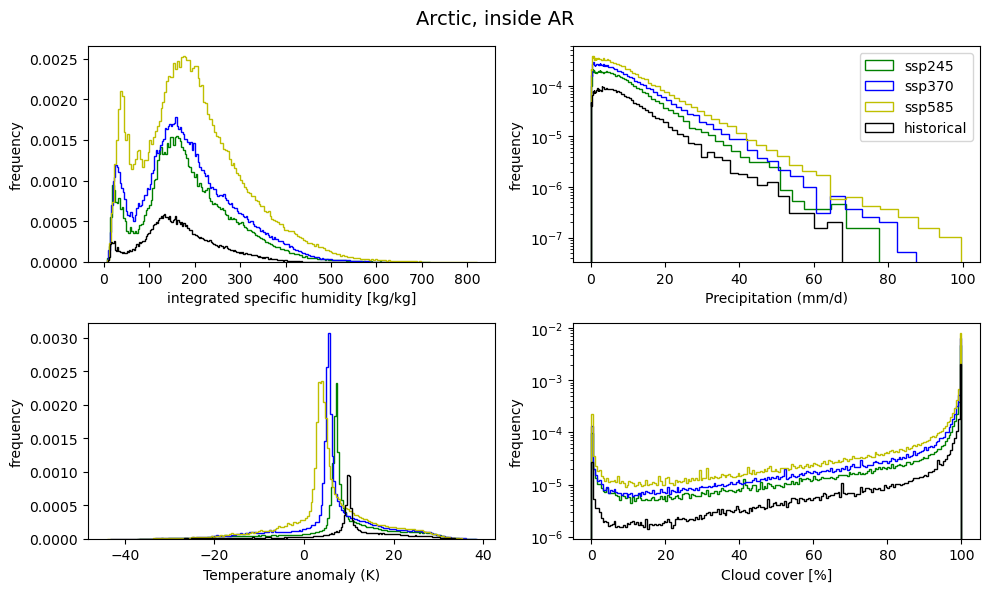

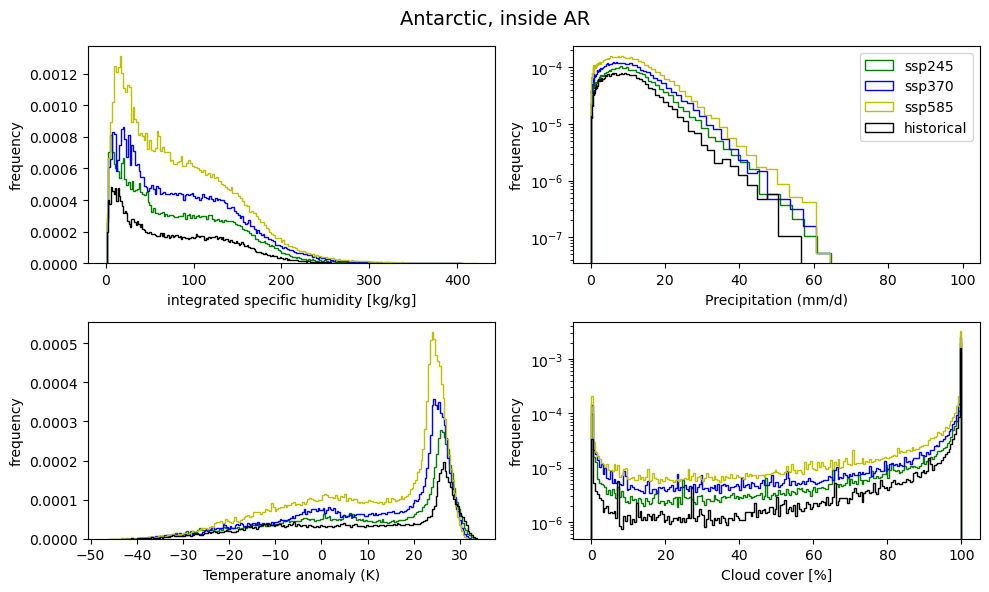

In [59]:
#### plot figures ####                                                     
fig, axs = plt.subplots(2,2, figsize=(10,6))
fig.suptitle('Arctic, inside AR', fontsize=14)
axs = axs.flatten()
axs[0].hist(int_hum['int_nh245'], weights = np.zeros_like(int_hum['int_nh245'])+1./int_hum['int_nh245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200)
axs[0].hist(int_hum['int_nh370'], weights = np.zeros_like(int_hum['int_nh370'])+1./int_hum['int_nh370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200)
axs[0].hist(int_hum['int_nh585'], weights = np.zeros_like(int_hum['int_nh585'])+1./int_hum['int_nh585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200)
axs[0].hist(int_hum['int_nhh'], weights = np.zeros_like(int_hum['int_nhh'])+1./int_hum['int_nhh'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200)
axs[0].set( xlabel = 'integrated specific humidity [kg/kg]', ylabel = 'frequency')

axs[1].hist(precip['np245'], weights = np.zeros_like(precip['np245'])+1./precip['np245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins=np.logspace(np.log10(np245.min()),np.log10(np245.max()),100))
axs[1].hist(precip['np370'], weights = np.zeros_like(precip['np370'])+1./precip['np370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins=np.logspace(np.log10(np370.min()),np.log10(np370.max()),100))
axs[1].hist(precip['np585'], weights = np.zeros_like(precip['np585'])+1./precip['np585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins=np.logspace(np.log10(np585.min()),np.log10(np585.max()),100))
axs[1].hist(precip['nph'], weights = np.zeros_like(precip['nph'])+1./precip['nph'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins=np.logspace(np.log10(nph.min()),np.log10(nph.max()),100)) 
axs[1].set(yscale ='log', xlabel = 'Precipitation (mm/d)', ylabel = 'frequency')
axs[1].legend() 
'''
axs[2].hist(aod['na245'], weights = np.zeros_like(aod['na245'])+1./aod['na245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200, )
axs[2].hist(aod['na370'], weights = np.zeros_like(aod['na370'])+1./aod['na370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200,)
axs[2].hist(aod['na585'], weights = np.zeros_like(aod['na585'])+1./aod['na585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200, )
axs[2].hist(aod['nah'], weights = np.zeros_like(aod['nah'])+1./aod['nah'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200, )
axs[2].set( xlim = (0,2.5), xlabel = 'AODat 500 nm', ylabel = 'frequency', yscale = 'log')
'''
axs[2].hist(temp_anom['nt245'], weights = np.zeros_like(temp_anom['nt245'])+1./temp_anom['nt245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins = 200)
axs[2].hist(temp_anom['nt370'], weights = np.zeros_like(temp_anom['nt370'])+1./temp_anom['nt370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins = 200)
axs[2].hist(temp_anom['nt585'], weights = np.zeros_like(temp_anom['nt585'])+1./temp_anom['nt585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins = 200)
axs[2].hist(temp_anom['nth'], weights = np.zeros_like(temp_anom['nth'])+1./temp_anom['nth'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins = 200)
axs[2].set(xlabel = 'Temperature anomaly (K)', ylabel = 'frequency')

axs[3].hist(cloud['nc245'], weights = np.zeros_like(cloud['nc245'])+1./cloud['nc245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins = 200)
axs[3].hist(cloud['nc370'], weights = np.zeros_like(cloud['nc370'])+1./cloud['nc370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins = 200)
axs[3].hist(cloud['nc585'], weights = np.zeros_like(cloud['nc585'])+1./cloud['nc585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins = 200)
axs[3].hist(cloud['nch'], weights = np.zeros_like(cloud['nch'])+1./cloud['nch'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins = 200)
axs[3].set(xlabel = 'Cloud cover [%]', ylabel = 'frequency', yscale = 'log')
plt.tight_layout()
plt.savefig('Arctic_future.png')


fig, axs = plt.subplots(2,2, figsize=(10,6))
fig.suptitle('Antarctic, inside AR', fontsize=14)
axs = axs.flatten()
axs[0].hist(int_hum['int_sh245'], weights = np.zeros_like(int_hum['int_sh245'])+1./int_hum['int_sh245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200)
axs[0].hist(int_hum['int_sh370'], weights = np.zeros_like(int_hum['int_sh370'])+1./int_hum['int_sh370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200)
axs[0].hist(int_hum['int_sh585'], weights = np.zeros_like(int_hum['int_sh585'])+1./int_hum['int_sh585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200)
axs[0].hist(int_hum['int_shh'], weights = np.zeros_like(int_hum['int_shh'])+1./int_hum['int_shh'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200)
axs[0].set( xlabel = 'integrated specific humidity [kg/kg]', ylabel = 'frequency')

axs[1].hist(precip['sp245'], weights = np.zeros_like(precip['sp245'])+1./precip['sp245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins=np.logspace(np.log10(np245.min()),np.log10(np245.max()),100))
axs[1].hist(precip['sp370'], weights = np.zeros_like(precip['sp370'])+1./precip['sp370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins=np.logspace(np.log10(np370.min()),np.log10(np370.max()),100))
axs[1].hist(precip['sp585'], weights = np.zeros_like(precip['sp585'])+1./precip['sp585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins=np.logspace(np.log10(np585.min()),np.log10(np585.max()),100))
axs[1].hist(precip['sph'], weights = np.zeros_like(precip['sph'])+1./precip['sph'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins=np.logspace(np.log10(nph.min()),np.log10(nph.max()),100)) 
axs[1].set(yscale ='log', xlabel = 'Precipitation (mm/d)', ylabel = 'frequency')
axs[1].legend() 
'''
axs[2].hist(aod['sa245'], weights = np.zeros_like(aod['sa245'])+1./aod['sa245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins= 200, )
axs[2].hist(aod['sa370'], weights = np.zeros_like(aod['sa370'])+1./aod['sa370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins= 200,)
axs[2].hist(aod['sa585'], weights = np.zeros_like(aod['sa585'])+1./aod['sa585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins= 200, )
axs[2].hist(aod['sah'], weights = np.zeros_like(aod['sah'])+1./aod['sah'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins= 200, )
axs[2].set( xlim = (0,2.5), xlabel = 'AODat 500 nm', ylabel = 'frequency', yscale = 'log')
'''
axs[2].hist(temp_anom['st245'], weights = np.zeros_like(temp_anom['st245'])+1./temp_anom['st245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins = 200)
axs[2].hist(temp_anom['st370'], weights = np.zeros_like(temp_anom['st370'])+1./temp_anom['st370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins = 200)
axs[2].hist(temp_anom['st585'], weights = np.zeros_like(temp_anom['st585'])+1./temp_anom['st585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins = 200)
axs[2].hist(temp_anom['sth'], weights = np.zeros_like(temp_anom['sth'])+1./temp_anom['sth'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins = 200)
axs[2].set(xlabel = 'Temperature anomaly (K)', ylabel = 'frequency')

axs[3].hist(cloud['sc245'], weights = np.zeros_like(cloud['sc245'])+1./cloud['sc245'].size, 
        fill = False, edgecolor='g', histtype = 'step', linewidth = 1, label = "ssp245", bins = 200)
axs[3].hist(cloud['sc370'], weights = np.zeros_like(cloud['sc370'])+1./cloud['sc370'].size, 
        fill = False, edgecolor='b', histtype = 'step', linewidth = 1, label = "ssp370", bins = 200)
axs[3].hist(cloud['sc585'], weights = np.zeros_like(cloud['sc585'])+1./cloud['sc585'].size, 
        fill = False, edgecolor='y',  histtype = 'step', linewidth = 1,label = "ssp585", bins = 200)
axs[3].hist(cloud['sch'], weights = np.zeros_like(cloud['sch'])+1./cloud['sch'].size, 
        fill = False, edgecolor='k', histtype = 'step', linewidth = 1, label = "historical", bins = 200)
axs[3].set(xlabel = 'Cloud cover [%]', ylabel = 'frequency', yscale = 'log')
plt.tight_layout()
plt.savefig('Antarctic_future.png')
                                                       
                                                       

KeyError: 'nthin'

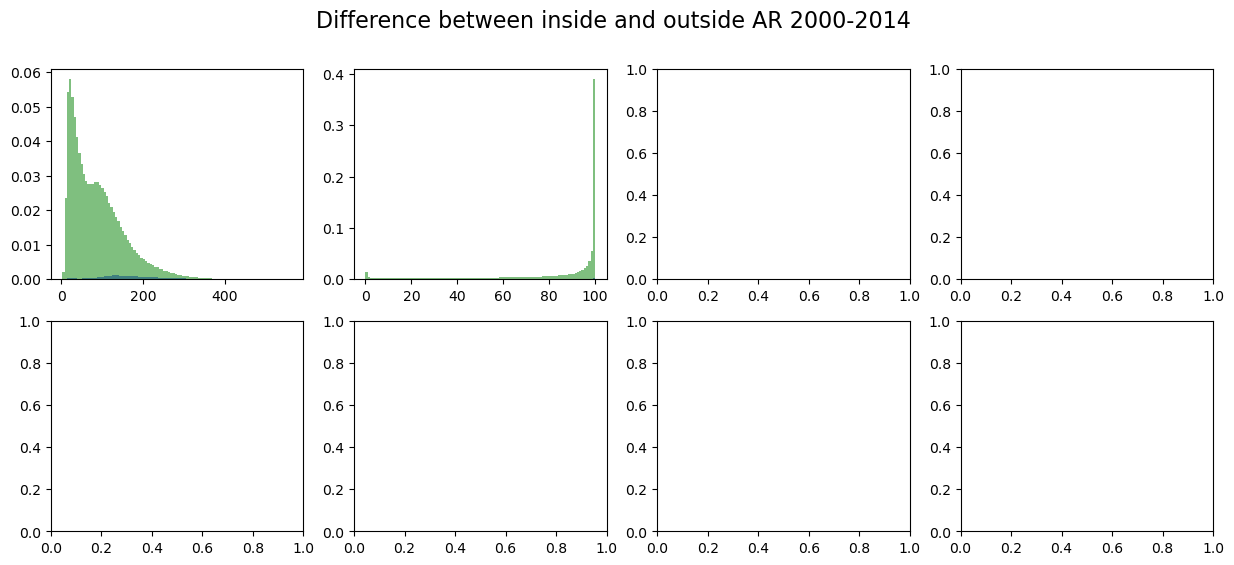

In [60]:
# plot parameters for antarctic and arctic
fig, axs = plt.subplots(2,4, figsize=(15,6))
axs = axs.flatten()
fig.suptitle('Difference between inside and outside AR 2000-2014', fontsize=16)

axs[0].hist(int_hum['int_nhh'], weights = np.zeros_like(int_hum['int_nhh'])+1./int_hum['int_nhh'].size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[0].hist(int_hum['neg_nih'], weights = np.zeros_like(int_hum['neg_nih'])+1./int_hum['neg_nih'].size, 
           alpha = 0.5, color = "g", label = "outside AR", bins=100)
axs[1].hist(cloud['nch'], weights = np.zeros_like(cloud['nch'])+1./cloud['nch'].size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[1].hist(cloud['neg_nch'],  weights = np.zeros_like(cloud['neg_nch'])+1./cloud['neg_nch'].size, 
           alpha = 0.5, color = "g", label = "outside AR", bins=100)
axs[2].hist(temp['nthin'], weights = np.zeros_like(temp['nthin'])+1./temp['nthin'].size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[2].hist(temp['neg_nth'], weights = np.zeros_like(temp['neg_nth'])+1./temp['neg_nth'].size, 
           alpha = 0.5, color = "g", label = "outside AR", bins=100)
axs[3].hist(precip['nph'], weights = np.zeros_like(precip['nph'])+1./precip['nph'].size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=np.logspace(np.log10(mp.min()),np.log10(mp.max()),100))
axs[3].hist(precip['neg_nph'], weights = np.zeros_like(precip['neg_nph'])+1./precip['neg_nph'].size,
           alpha = 0.5, color = "g", label = "outside AR", bins=np.logspace(np.log10(p.min()),np.log10(p.max()),100))
'''axs[9].hist(ma, weights = np.zeros_like(ma)+1./ma.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins = 100)
axs[9].hist(a, weights = np.zeros_like(a)+1./a.size,
           alpha = 0.5, color = "g", label = "outside AR", bins = 100)'''

axs[0].set(ylabel = 'fraction', xlabel = 'integrated specific humidity [kg/kg]')

axs[1].set(ylabel = 'fraction', xlabel = 'Cloud cover [%]', yscale ='log')
axs[2].set_title('Arctic', fontsize = 14)
axs[2].set(ylabel = 'fraction', xlabel = 'Temperature [K]')

axs[3].set(ylabel = 'fraction', xlabel = 'Precipitation [mm d$^-1$] ', xscale = 'log')

#axs[4].set(ylabel = 'fraction', xlabel = 'AOD at 550 nm ', xlim=(0,5), yscale = 'log')


axs[4].hist(int_hum['int_shh'], weights = np.zeros_like(int_hum['int_shh'])+1./int_hum['int_shh'].size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[4].hist(int_hum['neg_sih'], weights = np.zeros_like(int_hum['neg_sih'])+1./int_hum['neg_sih'].size, 
           alpha = 0.5, color = "g", label = "outside AR", bins=100)
axs[5].hist(cloud['sch'], weights = np.zeros_like(cloud['sch'])+1./cloud['sch'].size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[5].hist(cloud['neg_sch'],  weights = np.zeros_like(cloud['neg_sch'])+1./cloud['neg_sch'].size, 
           alpha = 0.5, color = "g", label = "outside AR", bins=100)
axs[6].hist(temp['sthin'], weights = np.zeros_like(temp['sthin'])+1./temp['sthin'].size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=100)
axs[6].hist(temp['neg_sth'], weights = np.zeros_like(temp['neg_sth'])+1./temp['neg_sth'].size, 
           alpha = 0.5, color = "g", label = "outside AR", bins=100)
axs[7].hist(precip['sph'], weights = np.zeros_like(precip['sph'])+1./precip['sph'].size, 
           alpha = 0.5, color = "b", label = "inside AR", bins=np.logspace(np.log10(mp.min()),np.log10(mp.max()),100))
axs[7].hist(precip['neg_sph'], weights = np.zeros_like(precip['neg_sph'])+1./precip['neg_sph'].size,
           alpha = 0.5, color = "g", label = "outside AR", bins=np.logspace(np.log10(p.min()),np.log10(p.max()),100))
'''axs[4].hist(maa, weights = np.zeros_like(maa)+1./maa.size, 
           alpha = 0.5, color = "b", label = "inside AR", bins = 100)
axs[4].hist(aa, weights = np.zeros_like(aa)+1./aa.size,
           alpha = 0.4, color = "g", label = "outside AR", bins = 100)'''

axs[5].set(ylabel = 'fraction', xlabel = 'Specific humidity [kg*m/s$^2$*kg/kg]')

axs[6].set(ylabel = 'fraction', xlabel = 'Cloud cover [%]', yscale ='log')
axs[7].set_title('Antarctic', fontsize = 14)
axs[7].set(ylabel = 'fraction', xlabel = 'Temperature [K]')

axs[8].set(ylabel = 'fraction', xlabel = 'Precipitation [mm d$^-1$] ', xscale = 'log')

#axs[9].set(ylabel = 'fraction', xlabel = 'AOD at 550 nm ', xlim=(0,1.5), yscale = 'log')
axs[1].legend()
plt.tight_layout()
plt.savefig('in_out_AR.png')

In [62]:
temp

,0
0,nthin
1,sthin
2,neg_nth
3,neg_sth
